# This note book to visualize learning from log files
One plot per metric in the log file (basically loss and METEOR).
Just update the log files list

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import re
from collections import OrderedDict
import os
from os.path import basename


In [12]:
# Global variables
maps_short=OrderedDict([('name', ''), ('embedding_dim', 'e'),('rnn_dim','r'),
                ('valid_beam','bm'),('batch_size','bs'),
                ('clip_c','gc'),     ('lrate','lr'),
                ('weight_init','i'), ('valid_freq', 'vf'), 
                ('suffix', ''), ('optimizer', '')])


In [13]:
class LogFile:
    #bs, beam, emb_dim, rnn_dim, filter, optim, decay
    #content, valid
    
    def __init__(self, id, logfn):
        self.fn = logfn
        self.metrics_names = {}
        self.values = {}
        self.best_scores = {}
        self.params={}
        self.pkeys=['name', 'batch_size', 'embedding_dim', 'rnn_dim', 'valid_beam', 'decay-c', 
               'clip_c', 'lrate', 'weight_init', 'valid_freq', 'optimizer' ]
        
        self.params['suffix'] = logfn.split('-')[-1].split('.')[0]
        if re.match('^s[0-9]+$', self.params['suffix']):
            self.params['suffix'] = ''
        self.params['name'] = str(id)+'_'+basename(logfn).split('-')[0]
        #print('SUFFIX:', self.params['suffix'])
        
        
        with open(logfn, 'r') as log:
            self.content = log.read().strip().split('\n')
        
        self.parse_params()
        self.parse_valid()
        self.get_best_scores()
        
    
    def parse_valid(self):
        self.valid = [ l for l in self.content if re.search(r'^Validation', l) ];
        self.metrics = {}
        for j, val in enumerate(self.valid):
            #print("valid", i, " val=", val)
            vals = re.split(' +|,', val)
            #vals = val.split() # BLEU as a comma after the score....
            name = vals[3]
            value = vals[5]
            if name not in self.metrics_names:
                #print("Adding new METRIC", name, " LINE=", val)
                self.metrics_names[name]=0
            if name not in self.values.keys():
                self.values[name] = [];
            #print("name=", name, " value=",value)
            self.values[name].append(value)
        
    
    def search(self, param, line):
        res=re.search('^ *{} : (.+)'.format(param), line)
        if res:
            return res.group(1)
        return None
    
    def parse_params(self):
        def get_float_not_int(s):
            try:
                int(s)
                return None
            except ValueError:
                try:
                    f=float(s)
                    return f
                except ValueError:
                    return None
            
        for line in self.content:
            for p in [ k for k in self.pkeys if k not in self.params.keys() ]:
                res=self.search(p, line)
                if res is not None:
                    #print('FOUND PARAM:', p, ' VALUE IS:', res)
                    fres=get_float_not_int(res)
                    if fres is not None:
                        res = '{:.0e}'.format(fres)
                        
                    #print("RES: ", res)
                    self.params[p]=res
                    break #no need to continue parsing this line for another param   
            if 'Initializing parameters' in line:
                #print("FOUND INIT, stopping: ", line)
                break
    
    def get_best_scores(self):
        for m in self.metrics_names:
            bestlines = [ l for l in self.content if "--> Current best {}".format(m.lower()) in l ];
            if bestlines:
                #print(bestlines[-1])
                score=re.search("{} is ([^ ]+) ".format(m), bestlines[-1]) # for loss
                if score:
                    #print("BEST {}: ".format(m), score.group(1))
                    self.best_scores[m] = score.group(1)
                else:
                    score=re.search("{} = ([^ ]+) ".format(m.upper()), bestlines[-1]) # for METEOR and BLEU
                    if score:
                        #print("BEST {}: ".format(m), score.group(1))
                        self.best_scores[m] = score.group(1)
                    else:
                        print("ERROR: can't parse best score for metric {}".format(m))
                        system.exit(1)
        
    
    def get_short_name(self, shared=None):
        
        sn= ''
        #print("SHORT KEYS: ", maps_short.keys())
        #print("SHARED KEYS: ", shared_params.keys())
        pdict=maps_short
        if shared:
            pdict = dict((key,value) for key, value in maps_short.iteritems() if key not in shared)
            
        for i, (k,v) in enumerate( pdict.iteritems() ):
            #print("i:", i, " k:",k, " v:", v)
            if i > 0 and self.params[k]:
                sn += '_'
            sn += '{}{}'.format(pdict[k], self.params[k])
        #print('sn=', sn)
        return sn
  
    def latexize(self, metrics_names, header=False):
        
        
        head = ''.ljust(len(self.get_short_name()))
        slatex = '{}'.format(self.get_short_name())
        for m,v in metrics_names.iteritems():
            if header is True:
                head += ' & {}'.format(m)
            #print("LATEX METRICS = ", m, " VALUE = ", v)
            if m in self.best_scores:
                #print("LATEX METRICS FOUND !")
                slatex += ' & {}'.format(self.best_scores[m])
            else:
                #print('{} is not in '.format(m), self.best_scores )
                slatex += ' & -'
        
        slatex += ' \\\\'
       
        if header is True:
            head += ' \\\\ \\hline' #always hline after header
            slatex = head+'\n'+slatex
    
        return slatex
            
        

            

In [14]:
def get_shared_params(logfiles):
    shared_str = ''
    shared_params = {}
    for k,v in maps_short.iteritems():
        if all( log.params[k] == logfiles[0].params[k] for log in logfiles ):
            #print('SHARED PARAM: ', k)
            if shared_str:
                shared_str += '-'
            shared_str += '{}{}'.format(v, logfiles[0].params[k])
            shared_params[k]=1
    return shared_str, shared_params
    

### Update the log file list here 

In [30]:
logfilenames = ( "w17news/attention-e512-r1024-adam_4e-04-bs32-meteor-each5000-l2_1e-05-gc5-init_xavier-s1235-new5k.1.log",
"w17news/attention-e512-r1024-adam_4e-04-bs32-meteor-each5000-l2_1e-05-do_0.2_0.4_0.4-gc5-init_xavier-s1235-dropout.1.log",
"w17news/attention-e512-r1024-adam_4e-04-bs32-meteor-each5000-l2_1e-05-gc5-init_xavier-s1235-compare_tc_notc.1.log",
"w17news/attention-e512-r1024-adam_4e-04-bs32-meteor-each5000-l2_1e-05-gc5-init_xavier-s1235.1.log",
"w17news/attention-e512-r1024-adam_4e-04-bs32-meteor-each5000-l2_1e-05-do_0.2_0.2_0.4-gc5-init_xavier-s1235-small-ctx-do.1.log",
#"w17news/attention-e512-r1024-adadelta_4e-04-bs32-meteor-each5000-l2_1e-05-gc5-init_xavier-s1235-adadelta.1.log",
"w17news/attention-e512-r1024-adam_4e-04-bs32-bleu-each5000-l2_1e-05-gc5-init_xavier-s1235-optim_bleu.1.log",
"w17news/attention-e512-r1024-adam_4e-04-bs32-meteor-each5000-l2_1e-05-gc5-init_xavier-s1235-btUEDIN.1.log",
 )

## Load logfiles and extract information

In [31]:
logfiles = []
metrics_names = {}

for i, logfn in enumerate(logfilenames):
    #print("log ", i, " = ", logfn);
    log=LogFile(i,logfn)
    metrics_names.update(log.metrics_names)
    logfiles.append(log)
    #log.parse()
    #log.get_short_name()
    
#print("metrics len:", len(metrics_names))

shared_str, shared_params = get_shared_params(logfiles)

# Plotting

No BLEU in 0_attention_new5k
No BLEU in 1_attention_dropout
No BLEU in 2_attention_compare_tc_notc
No BLEU in 3_attention
No BLEU in 4_attention_do
No BLEU in 6_attention_btUEDIN
No METEOR in 5_attention_optim_bleu


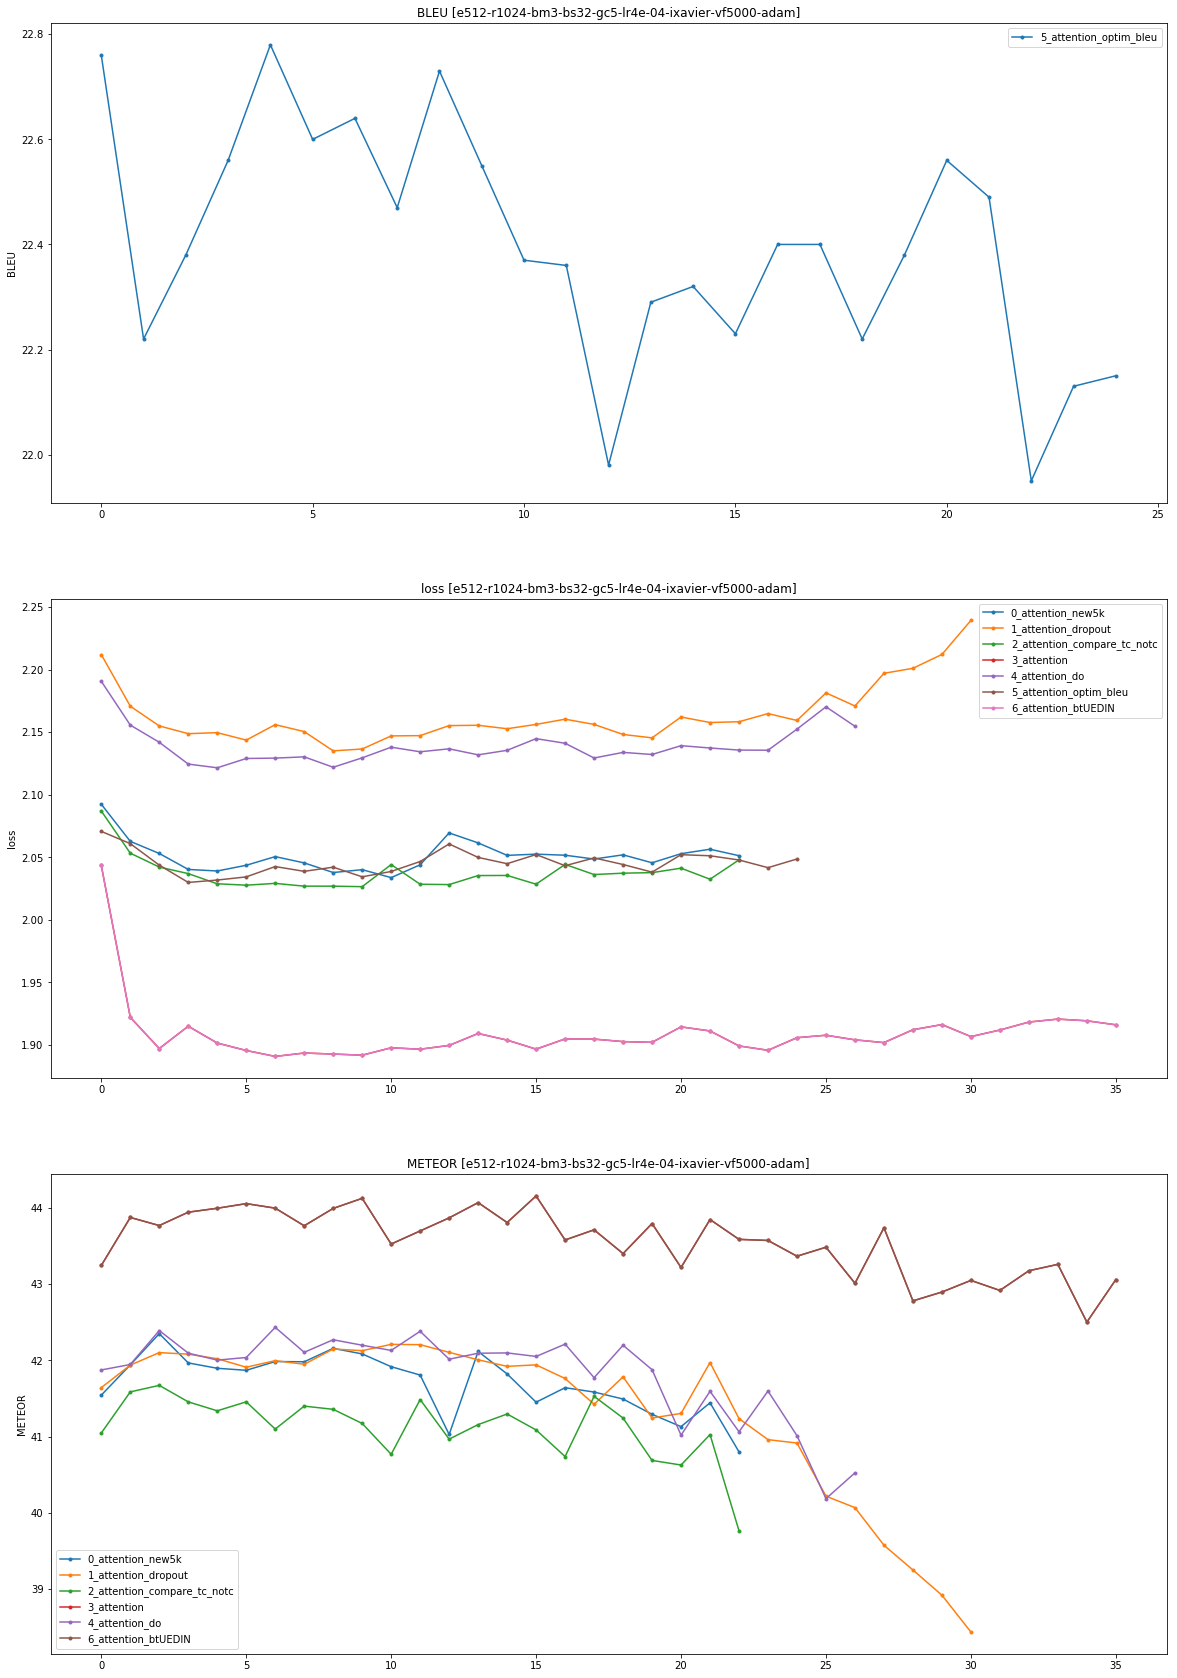

In [32]:
# plotting    
fig, ax = plt.subplots(len(metrics_names), 1, sharey = False, figsize=(20, 30) )
for i, n in enumerate(metrics_names.keys()):    
    sp = ax[i]
    sp.set_ylabel(n)
    for j, log in enumerate(logfiles):
        #print("PROCESSING LOGFILE:", log.fn)
        #print("METRICS IN THIS FILE:", log.metrics_names)
        if n in log.metrics_names.keys():
            #print(n+" "+str(j)+":",log.values[n])
            sp.plot(log.values[n], '.-', label=log.get_short_name(shared_params))
        else:
            print('No {} in {}'.format(n, log.get_short_name(shared_params)))
    
    title = '{} [{}]'.format(n, shared_str) if shared_str else '{}'.format(n)
    sp.set_title(title)
    sp.legend( )


plt.show()      
   

## LATEX 

In [33]:
# LATEX

for i, log in enumerate(logfiles):    
    ltx=log.latexize(metrics_names, header=True if i is 0 else False)
    print(ltx)

                                                                      & BLEU & loss & METEOR \\ \hline
0_attention_e512_r1024_bm3_bs32_gc5_lr4e-04_ixavier_vf5000_new5k_adam & - & 2.03379 & 42.35114 \\
1_attention_e512_r1024_bm3_bs32_gc5_lr4e-04_ixavier_vf5000_dropout_adam & - & 2.13514 & 42.21070 \\
2_attention_e512_r1024_bm3_bs32_gc5_lr4e-04_ixavier_vf5000_compare_tc_notc_adam & - & 2.02655 & 41.67295 \\
3_attention_e512_r1024_bm3_bs32_gc5_lr4e-04_ixavier_vf5000_adam & - & 1.89082 & 44.15665 \\
4_attention_e512_r1024_bm3_bs32_gc5_lr4e-04_ixavier_vf5000_do_adam & - & 2.12159 & 42.43352 \\
5_attention_e512_r1024_bm3_bs32_gc5_lr4e-04_ixavier_vf5000_optim_bleu_adam & 22.78, & 2.02992 & - \\
6_attention_e512_r1024_bm3_bs32_gc5_lr4e-04_ixavier_vf5000_btUEDIN_adam & - & 1.89082 & 44.15665 \\


### Loïc Barrault